In [25]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, convert_mask_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

device = 'cuda:7'

load attribution, interpolation

In [27]:

attr_path  = {
    'zero': '/home/dhlee/results/cifar10/image_linear_zero_attribution.npy',
    'expected': '/home/dhlee/results/cifar10/image_linear_expected_attribution.npy',
    
    'image_gradient': '/home/dhlee/results/cifar10/image_gradient_attribution.npy', # descent
    
    'latent_linear': '/home/dhlee/results/cifar10/latent_linear_attribution.npy',
    
    'image_gradient_ascent': '/home/dhlee/results/cifar10/image_gradient_ascent_attribution.npy',
    
    'latent_gradient': '/home/dhlee/results/cifar10/latent_gradient_attribution.npy',
    'latent_gradient_ascent': '/home/dhlee/results/cifar10/latent_gradient_ascent_attribution.npy',
}

In [28]:
def make_key(keys, method, ratio):
    ans = []
    for i in keys:
        if method in i:
            if ratio in i:
                ans.append(i)
    return i
                

Show metric

In [29]:
import json

with open("/home/dhlee/code/ig_inversion/results/evaluation_average_cifar10.json", "r") as st_json:
    avg = json.load(st_json)


['lodds_expected_0.2', 'lodds_image_gradient_ascent_0.2', 'lodds_image_gradient_descent_0.2', 'lodds_latent_gradient_ascent_0.2', 'lodds_latent_gradient_descent_0.2', 'lodds_latent_linear_0.2', 'lodds_zero_0.2']
[-3.4389291442789696, -3.0978296357271176, -3.6830000958919693, -3.0336978034101834, -3.2902841577340425, -3.4587500515973195, -4.029558909782774]


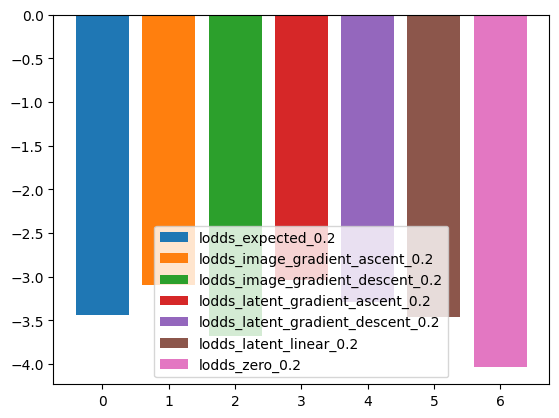

In [50]:
method = "lodds"
ratio = "0.2"

check_key = []
for i in list(avg.keys()):
    if ratio in i:
        if method in i:
            # print(i)
            check_key.append(i)

print(check_key)

result = []
for i in check_key:
    result.append(avg[f'{i}'])

print(result)
                
for i in range(len(check_key)):
    plt.bar(i, result[i], label = f'{check_key[i]}')
    plt.legend(loc = 8)
    # plt.bar(check_key, result)


In [22]:
pr = 'aopc_image_gradient_0.01'
re = "".join(reversed(pr))
print(pr.find('_'))
print(re.find('_'))
print(len(pr)- re.find('_'))
print(pr[4], pr[20 - 1])
print(pr[4+1:20-1])

4
4
20
_ _
image_gradient


In [40]:
check_key[0]

'aopc_expected_0.05'

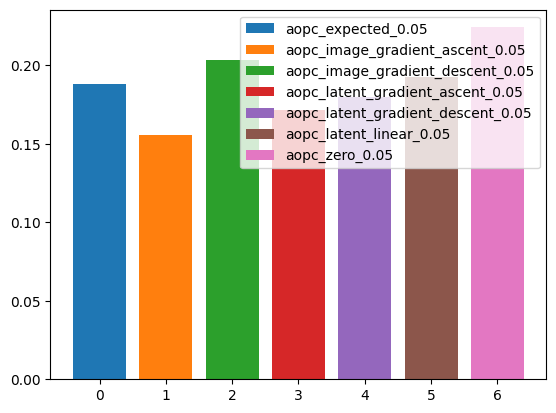

In [33]:
import pandas as pd

data = pd.DataFrame.from_dict(avg, orient = 'index')
data


,0
aopc_expected_0.01,0.054342
aopc_expected_0.05,0.188144
aopc_expected_0.1,0.396177
aopc_expected_0.15,0.476706
aopc_expected_0.2,0.447014
...,...
morf_zero_0.01,0.853000
morf_zero_0.05,0.712500
morf_zero_0.1,0.581300
morf_zero_0.15,0.466100


show interpolation